In [1]:
import numpy as np
import pandas as pd
import matplotlib

# Distributions
from explicalib.distribution.multiclass_multimodal_multivariate_gaussian_distribution import MulticlassMultimodalMultivariateGaussianDistribution

# ML
from explicalib.probabilistic_classifiers import RandomForestClassifier, LogisticRegression
from sklearn.model_selection import train_test_split

# Diagrams
import matplotlib.pyplot as plt
from explicalib.calibration.evaluation.plots.binary.binary_reliability import plot_binary_reliability_diagram
from explicalib.calibration.evaluation.plots.binary.binary_reliability_curve import plot_binary_reliability_curve
from explicalib.calibration.evaluation.plots.binary.bootstrapped_binary_reliability_curve import plot_bootstrapped_binary_reliability_curve

# Experimental setup
from explicalib.experiments.setups.comparison_with_gt.utils import load_all

In [2]:
reproducible = np.random.RandomState(1)

# Figures

This notebook contains the code used to generate the figures in the paper.

## Fig. 1

In [3]:
# Common arguments for the 3 plots

FONT = {'family': 'DejaVu Sans', 'size': 25}
LEGEND_LOC = "upper left"
N_BINS = 15
BANDWIDTH = 0.03

In [4]:
distribution = MulticlassMultimodalMultivariateGaussianDistribution.randomly_set(n_classes=2, 
                                                                                 n_features=7, 
                                                                                 means_radius=1, 
                                                                                 n_modes_per_class=4,
                                                                                 covariances_radius=0.3, 
                                                                                 mode_weights="uniform", 
                                                                                 reproducible=reproducible)

X, Y, P = distribution.sample(n_samples=50000, reproducible=reproducible)

X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, Y, train_size=300, random_state=reproducible)

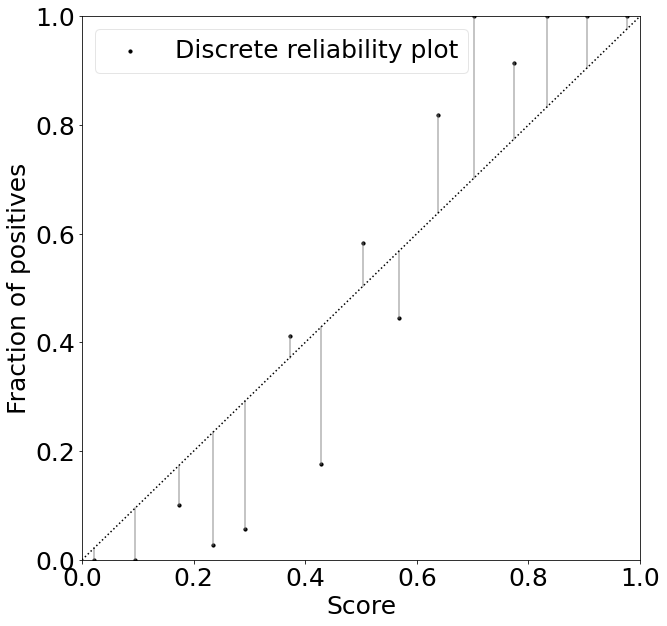

In [5]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)

plot_binary_reliability_diagram(model=model, 
                                X=X_holdout[:1000], Y=Y_holdout[:1000], 
                                n_bins=N_BINS, 
                                font=FONT,
                                show_score_distribution=False, title=None, 
                                legend_loc=LEGEND_LOC, legend_framealpha=0.5)

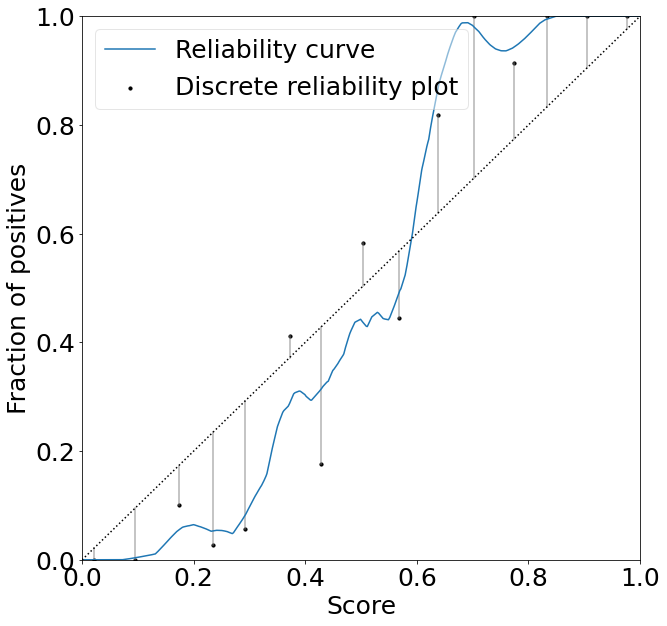

In [6]:
plot_binary_reliability_curve(model=model, 
                              X=X_holdout[:1000], Y=Y_holdout[:1000], 
                              n_bins=N_BINS, bandwidth=BANDWIDTH,
                              show_score_distribution=False, title=None, 
                              font=FONT, 
                              legend_loc=LEGEND_LOC, legend_framealpha=0.5)

100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


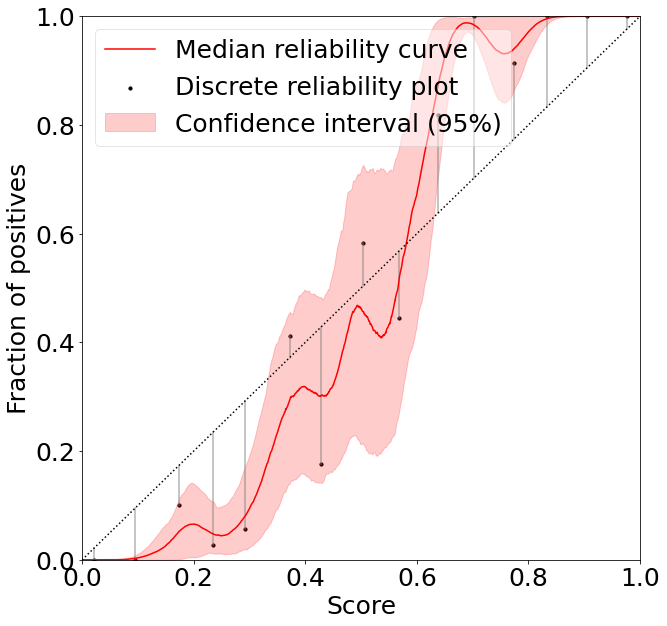

In [7]:
plot_bootstrapped_binary_reliability_curve(model=model, 
                                           X=X_holdout[:1000], Y=Y_holdout[:1000], 
                                           n_bins=N_BINS, bandwidth=BANDWIDTH, n_samplings=500, confidence_interval=0.95,
                                           show_score_distribution=False, title=None, 
                                           font=FONT, 
                                           curve_color="red", 
                                           legend_loc=LEGEND_LOC, legend_framealpha=0.5)

##  Fig. 2

In [ ]:
CLASSWISE = "classwise"
CONFIDENCE = "confidence"

def filter_in(reports):
    reports_filtered = []
    for report in reports:
        if report["n_classes"] not in (2, 5, 7):
            continue
        if report["n_features"] not in (2, 5, 7):
            continue
        if report["seed_train_test_split"] not in (0, 1, 2):
            continue
        if report["model_family.__name__"] not in ["SVCc", "GaussianNB", "LogisticRegression", "RandomForestClassifier"]:
            continue
        if report["seed_distribution"] > 4:
            continue
        if report["metric.__name__"] == "classwise_ece_ma" or report["metric.__name__"] == "confidence_ece_ma":
            continue
    
        reports_filtered.append(report)
        
    return reports_filtered

reports_cw = load_all(setup_name=CLASSWISE, protocol=4)
columns_cw = reports_cw.columns

reports_conf = load_all(setup_name=CONFIDENCE, protocol=4)
columns_conf = reports_conf.columns

reports_cw = filter_in(reports_cw.to_dict(orient='records'))
reports_conf = filter_in(reports_conf.to_dict(orient='records'))

In [9]:
import copy
from explicalib.experiments.setups.comparison_with_gt.utils import group_by

def add_normalized_trajectories(reports):
    """
    Takes as inputs:
    - reports : a list of reports
    Returns
    The same list with added normalized median distance and normalized 95% trajectory.
    """
    
    res = []
    for report in reports:
        report2 = copy.deepcopy(report)

        gt = report["gt"]

        report2["medians_norm"] = report["medians"] / gt
        report2["highs_norm"] = report["highs"] / gt

        res.append(report2)

    return res


def aggregate_by_metric_complete(reports):
    def aggregate(group):
        result = {}

        d = np.stack([report["medians"] for report in group])
        distance_medians_gt_norm = np.median(d, axis=0)
        result["medians"] = distance_medians_gt_norm

        d = np.stack([report["highs"] for report in group])
        distance_highs_gt_norm = np.median(d, axis=0)
        result["highs"] = distance_highs_gt_norm

        result["n_samples_calibration_evaluations"] = group[0]["n_samples_calibration_evaluations"]

        # All groupped reports share the same metric settings
        result["metric.__name__"] = group[0]["metric.__name__"]
        result["metric_kwargs"] = group[0]["metric_kwargs"]
        result["metric_complete"] = group[0]["metric_complete"]

        return result

    reports_groupped = group_by(reports, key="metric_complete")
    reports_aggregated = [aggregate(group) for group in reports_groupped]

    return reports_aggregated

In [10]:
def plot_all(reports_classwise, reports_confidence, font):
    
    # Some nice dicts for quick formatting of labels/colours/style
    metric_name_to_colors = {
        "classwise_ece": "k",
        "direct_classwise_ece": "g",
        "classwise_ece_a": "r",
        "classwise_ece_ma": "orange",
        "classwise_ece_c": "b",
        "classwise_ece_ac": "m",

        "confidence_ece": "k",
        "direct_confidence_ece": "g",
        "confidence_ece_a": "r",
        "confidence_ece_ma": "orange",
        "confidence_ece_c": "b",
        "confidence_ece_ac": "m",

        "binary_ece": "k",
        "direct_binary_ece": "g",
        "binary_ece_a": "r",
        "binary_ece_ma": "orange",
        "binary_ece_c": "b",
        "binary_ece_ac": "m",
    }

    metric_complete_to_linestyle = {
        "sqrt": "--",
        "silverman": "-.",
    }
    metric_complete_to_alpha = {
        "{'n_bins': 10}": 1.0,
        "{'n_bins': 20}": 0.7,
        "{'n_bins': 30}": 0.4,
        "{'bandwidth': 0.01}": 0.4,
        "{'bandwidth': 0.033}": 0.7,
        "{'bandwidth': 0.05}": 0.8,
        "{'bandwidth': 0.1}": 1.0,
    }
    metric_name_to_clean_metric_name = {
        "binary_ece": "$ECE^1$",
        "binary_ece_c": "$ECE^1_c$",
        "binary_ece_a": "$ECE^1_a$",
        "binary_ece_ma": "$ECE^1_{ma}$",
        "binary_ece_ac": "$ECE^1_{ac}$",
        "direct_binary_ece": "$ECE^1_{kde}$",

        "confidence_ece": "$ECE^{conf}_l$",
        "confidence_ece_c": "$ECE^{conf}_c$",
        "confidence_ece_a": "$ECE^{conf}_a$",
        "confidence_ece_ma": "$ECE^{conf}_{ma}$",
        "confidence_ece_ac": "$ECE^{conf}_{ac}$",
        "direct_confidence_ece": "$ECE^{conf}_{kde}$",

        "classwise_ece": "$ECE^{cw}_l$",
        "classwise_ece_c": "$ECE^{cw}_c$",
        "classwise_ece_a": "$ECE^{cw}_a$",
        "classwise_ece_ma": "$ECE^{cw}_{ma}$",
        "classwise_ece_ac": "$ECE^{cw}_{ac}$",
        "direct_classwise_ece": "$ECE^{cw}_{kde}$",
    }
    
    # Setting font for the plot.
    matplotlib.rc('font', **font)

    # Experimental data processing
    
    # Adding normalized trajectories
    reports_classwise = add_normalized_trajectories(reports_classwise)
    reports_confidence = add_normalized_trajectories(reports_confidence)

    # Aggregating reports with the same metric_complete
    reports_classwise = aggregate_by_metric_complete(reports_classwise)
    reports_confidence = aggregate_by_metric_complete(reports_confidence)

    # Sorting reports for consistent colors on both plots
    reports_classwise = sorted(reports_classwise, key=lambda report: report["metric_complete"])
    reports_confidence = sorted(reports_confidence, key=lambda report: report["metric_complete"])

    # Creating figure
    fig = plt.figure(figsize=(11, 11))
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0]) # Top plot
    ax2 = fig.add_subplot(gs[1, 0]) # Bottom plot

    # Organizing class-wise curves
    legends_cw = {}
    for report in reports_classwise:

        # Renaming metric_complete for concision
        metric_complete = report["metric_complete"]
        metric_complete = metric_complete.replace("classwise_", "").replace("binary_", "").replace("confidence_", "")

        # Adding report to the correct legend
        metric_name = report["metric.__name__"]
        if metric_name not in legends_cw:
            legends_cw[metric_name] = []
        legends_cw[metric_name].append((metric_complete, report))
        
    # Organizing confidence curves
    legends_conf = {}
    for report in reports_confidence:

        # Renaming metric_complete for concision
        metric_complete = report["metric_complete"]
        metric_complete = metric_complete.replace("classwise_", "").replace("binary_", "").replace("confidence_", "")

        # Adding report to the correct legend
        metric_name = report["metric.__name__"]
        if metric_name not in legends_conf:
            legends_conf[metric_name] = []
        legends_conf[metric_name].append((metric_complete, report))
    
    # Populating top figure
    for metric_name in legends_conf:

        # Getting display metric name
        clean_metric_name = metric_name_to_clean_metric_name[metric_name]

        # Iterating through the trajectories of different hyperparameters
        for metric_complete, report in legends_conf[metric_name]:

            # Setting linestyle
            linestyle = "solid"
            for part in metric_complete_to_linestyle:
                if part in report["metric_complete"]:
                    linestyle = metric_complete_to_linestyle[part]

            # Setting color
            color = "fuchsia"
            for metric_name in metric_name_to_colors:
                if metric_name == report["metric.__name__"]:
                    color = metric_name_to_colors[metric_name]

            # Setting alpha
            alpha = 1
            for part in metric_complete_to_alpha:
                if part in report["metric_complete"]:
                    alpha = metric_complete_to_alpha[part]

            # Cleaning up metric_complete
            metric_complete = report["metric_complete"]
            metric_complete = metric_complete.replace("classwise_", "").replace("binary_", "").replace("confidence_",
                                                                                                       "")
            metric_name = report["metric.__name__"]
            metric_kwargs = report["metric_kwargs"]

            # Hyperparams display
            if metric_kwargs == "{'n_bins': 'sqrt'}":
                metric_kwargs = "sqrt"
            elif metric_kwargs == "{'bandwidth': 'silverman'}":
                metric_kwargs = "Silverman"
            elif "n_bins" in metric_kwargs:
                n_bins = metric_kwargs.split(" ")[1][:-1]
                metric_kwargs = str(n_bins) + " bins"
            elif "bandwidth" in metric_kwargs:
                bandwidth = metric_kwargs.split(" ")[1][:-1]
                metric_kwargs = "bandwidth : " + str(bandwidth)

            p = ax1.plot(report["n_samples_calibration_evaluations"], report["highs"],
                       linestyle=linestyle, color=color, alpha=alpha)

    # Populating bottom figure
    for metric_name in legends_cw:

        # Getting display metric name
        clean_metric_name = metric_name_to_clean_metric_name[metric_name]
        
        # Displaying it in the legend via a ghost plot
        ax2.plot([0, 1], [-1, -1], marker='o', linestyle="None", label=clean_metric_name.replace("^{cw}",""),
                 color=metric_name_to_colors[metric_name])

        # Iterating through the trajectories of different hyperparameters
        for metric_complete, report in legends_cw[metric_name]:

            # Setting linestyle
            linestyle = "solid"
            for part in metric_complete_to_linestyle:
                if part in report["metric_complete"]:
                    linestyle = metric_complete_to_linestyle[part]

            # Setting color
            color = "fuchsia"
            for metric_name in metric_name_to_colors:
                if metric_name == report["metric.__name__"]:
                    color = metric_name_to_colors[metric_name]

            # Setting alpha
            alpha = 1
            for part in metric_complete_to_alpha:
                if part in report["metric_complete"]:
                    alpha = metric_complete_to_alpha[part]

            # Cleaning up metric_complete
            metric_complete = report["metric_complete"]
            metric_complete = metric_complete.replace("classwise_", "").replace("binary_", "").replace("confidence_",
                                                                                                       "")
            metric_name = report["metric.__name__"]
            metric_kwargs = report["metric_kwargs"]

            # Hyperparams display
            if metric_kwargs == "{'n_bins': 'sqrt'}":
                metric_kwargs = "sqrt"
            elif metric_kwargs == "{'bandwidth': 'silverman'}":
                metric_kwargs = "Silverman"
            elif "n_bins" in metric_kwargs:
                n_bins = metric_kwargs.split(" ")[1][:-1]
                metric_kwargs = str(n_bins) + " bins"
            elif "bandwidth" in metric_kwargs:
                bandwidth = metric_kwargs.split(" ")[1][:-1]
                metric_kwargs = "bandwidth : " + str(bandwidth)

            p = ax2.plot(report["n_samples_calibration_evaluations"], report["highs"],
                         label=metric_kwargs, linestyle=linestyle, color=color, alpha=alpha)
            
            # Putting a space in the legend between types of estimators
            if metric_complete == legends_cw[metric_name][-1][0] :
                ax2.plot([0, 1], [-1, -1], marker='o', label=" ", color="white")
                
    # Displayed ticks on both plots
    XTICKS = [30, 50, 100, 200, 500]
    YTICKS_CONF = [0.03, 0.04, 0.2, 0.4]
    YTICKS_CLASSW = [0.01, 0.02, 0.1, 0.2]
            
    # Configuring top plot
    ax1.set_xlim(30, 500)
    ax1.set_ylim(min(YTICKS_CONF), max(YTICKS_CONF))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xticks(XTICKS)
    ax1.set_yticks(YTICKS_CONF)
    ax1.set_ylabel('Approximation error')
    ax1.title.set_text('Confidence setting')
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.grid()

    # Configuring bottom plot
    ax2.set_xlim(30, 500)
    ax2.set_ylim(min(YTICKS_CLASSW), max(YTICKS_CLASSW))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xticks(XTICKS)
    ax2.set_yticks(YTICKS_CLASSW)
    ax2.set_ylabel('Approximation error')
    ax2.set_xlabel('Holdout evaluation set size')
    ax2.title.set_text('Class-wise setting')
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.grid()

    plt.tight_layout()
    
    plt.legend(
        loc="center",
        bbox_to_anchor=(1.2,1.1),
    )

    plt.show()

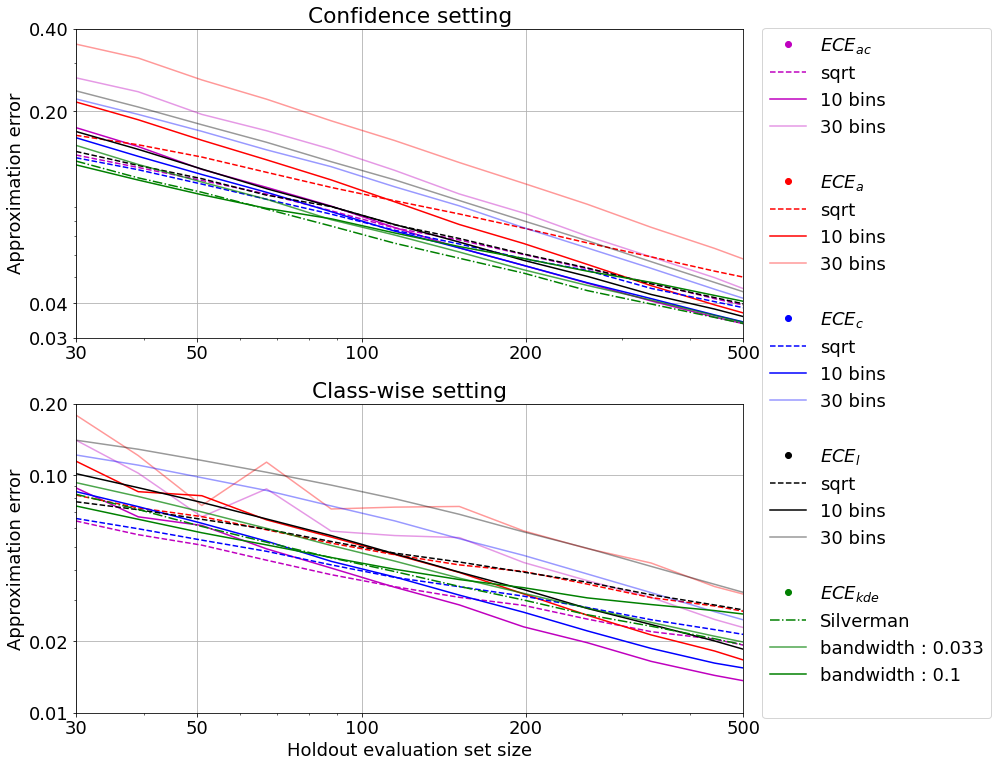

In [11]:
plot_all(reports_classwise=reports_cw, reports_confidence=reports_conf, font={'family': 'DejaVu Sans', 'size': 18})